In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as skimage
import scipy

from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse.linalg import lsqr

# note we imported the sparse least squares function  

In [3]:
# take some images with different exposure times.  
# make sure your camera (phone) does not move between exposures. I used a phone tripod.

# images
Ims = []
# exposure times
dts = []

Ims.append(plt.imread('0.3.jpeg'))
dts.append(0.3)

Ims.append(plt.imread('0.7.jpeg'))
dts.append(0.7)

Ims.append(plt.imread('1.0.jpeg'))
dts.append(1.0)

Ims.append(plt.imread('1.3.jpeg'))
dts.append(1.3)

Ims.append(plt.imread('1.7.jpeg'))
dts.append(1.7)

Ims.append(plt.imread('2.0.jpeg'))
dts.append(2.0)


In [4]:
# resize the images to a reasonable scale 
Imsr = []
for idx in range(len(Ims)):
    # note this will resize factor of 1/8 for each side and convert to type float
    
    # "cheap" conversion from color to gray scale by taking the mean of rgb values
    I = np.mean(Ims[idx],axis=2)
    # resize to 1/8 of each dimension
    Ir=skimage.transform.resize(I, (I.shape[0] // 8, I.shape[1] // 8), anti_aliasing=True)
    Imsr.append(Ir)
    print(f"Imsr[{idx}].shape={Imsr[idx].shape} Imsr[{idx}].dtype={Imsr[idx].dtype} ",end="")
    print(f"values from {np.min(Imsr[idx][:])} to {np.max(Imsr[idx][:])}")
    
    # convert to uint8 (forcing a value from 0..255) just to have discrete pixel values
    Imsr[idx]=Imsr[idx].astype("uint8")
    print(f"Imsr[{idx}].shape={Imsr[idx].shape} Imsr[{idx}].dtype={Imsr[idx].dtype} ",end="")
    print(f"values in {np.min(Imsr[idx][:])} .. {np.max(Imsr[idx][:])}")
    print(f"dts[{idx}]={dts[idx]}")
    

Imsr[0].shape=(378, 504) Imsr[0].dtype=float64 values from 0.004456972394747381 to 250.5133799777326
Imsr[0].shape=(378, 504) Imsr[0].dtype=uint8 values in 0 .. 250
dts[0]=0.3
Imsr[1].shape=(378, 504) Imsr[1].dtype=float64 values from 0.0896441084693942 to 249.7611209133078
Imsr[1].shape=(378, 504) Imsr[1].dtype=uint8 values in 0 .. 249
dts[1]=0.7
Imsr[2].shape=(378, 504) Imsr[2].dtype=float64 values from 0.47634617304887084 to 249.89565521939866
Imsr[2].shape=(378, 504) Imsr[2].dtype=uint8 values in 0 .. 249
dts[2]=1.0
Imsr[3].shape=(378, 504) Imsr[3].dtype=float64 values from 0.4790356188695498 to 248.43947559431865
Imsr[3].shape=(378, 504) Imsr[3].dtype=uint8 values in 0 .. 248
dts[3]=1.3
Imsr[4].shape=(378, 504) Imsr[4].dtype=float64 values from 0.07820665742315405 to 254.267621395592
Imsr[4].shape=(378, 504) Imsr[4].dtype=uint8 values in 0 .. 254
dts[4]=1.7
Imsr[5].shape=(378, 504) Imsr[5].dtype=float64 values from 0.24451664195379066 to 254.72603680932886
Imsr[5].shape=(378, 504)

In [6]:
# simple version of optimization

# solving for entries in v
# first 256 entries are for g(0) ... g(255) then next h*w entries are for pixel brightnesses
#
# Z_ij is the pixel value at location i in image j
# dt_j is the exposure time for image j
# g(z) is the energy x that the sensor receives (exposure) to produce pixel value z
#      (the exposure is the irradiance R times exposure time)
#
#  x = R*dt
#  for pixel i in image j
#  x_ij = R_ij*dt_j
#
#  Z_ij = f(x_ij)  # the pixel value Z_ij comes from mapping the exposure through some function f
#  g() is the inverse of f()
#  
#  so if Z_ij = f(x_ij) we want g(Z_ij)=x_ij (=R_ij*dt_j)
#
#  taking logs of everything:
#
# g(Z_ij) = ln(R_i)+ln(dt_j) # pixel i,image j with time dt_j
# g(Z_ij) - ln(R_i) = ln(dt_j)
#
# making this into a constraint
#
# Each pixel i in imag j gives one row of A and one entry in b
# position: 0...... Z_ij ...255 0 1 2 ... i*w+j ... h*w
# coefficient: 0 0 ... 1.......0 0 .......... -1 ......0
#
# entry in b: ln(dt_j)
#
#  We want to solve for v so that Av=b
#  or the v that minimizes |Av-b|^2


[h,w]=Imsr[0].shape
l = len(Imsr)
r = l * h * w
c = 256 + h * w
A = lil_array((r + 1, c))
b = np.zeros(r + 1)

row = 0
check = 0
for j in range(l):
    for i in range(h):
        for k in range(w):
            Z_ij = Imsr[j][i, k]
            A[row, Z_ij] = 1
            A[row, i * w + k + 256] = -1
            b[row] = np.log(dts[j])
            row += 1

            

A[c, 128] = 1
b[c] = np.log(4)

# setup rows of A and entries in b

# add a constraint that "fixes" g(128) to be say 4 or such


In [7]:
#solve for least squares solution
Acsr=csr_array(A)# convert a to a csrarray before calling least squares
soln = lsqr(Acsr,b,atol=1e-07, btol=1e-07)
v = soln[0]

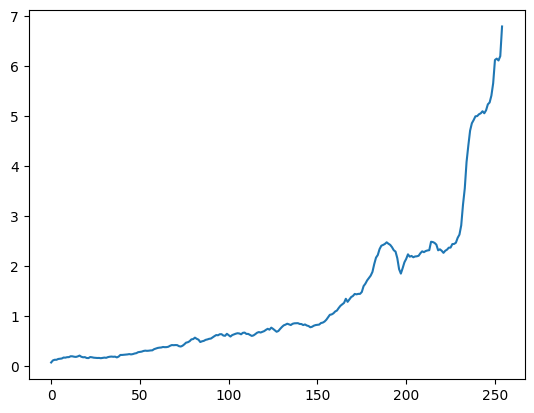

In [9]:
plt.plot(np.exp(v[0:255]))

In [24]:
# Adding some bells and whistles to the optimization setup
#
#
# solving for entries in v
# first 256 entries are for g(0) ... g(255) then next h*w entries are for pixel brightnesses
# g(x) = ln(R_i)+ln(dt_j) # pixel i,image j with time dt_j
# g(x) - ln(R_i) = ln(dt_j)
#
# weighted version where weight depends on the pixel value (can care less about 0..5 and 250-255) 
# w(R_i)g(x) - q(R_i)ln(R_i) = w(R_i)ln(dt_j)
#
# also add regularization so that g(x) tends to be smooth
#
# l(g(i+1)-g(i)) - l(g(i)-g(i-1)) = 0
# lg(i)-2g(i+1)-g(i+2) = 0
#
# where l is some weight on this constraint
#
# remember to add a constraint that "fixes" g(128) to be say 4 or such

# make a new version of A and b with these weights and constraints


# Assume Imsr is a list of image arrays and dt is a list of exposure times
[h, w] = Imsr[0].shape
l = len(Imsr)

# Total number of variables and equations, plus regularization terms and the extra constraint
c = 256 + h * w
r = l * h * w + 256 - 2 + 1  # Additional -2 for the first and last g(x) regularization, +1 for g(128) constraint

A = lil_array((r, c))
b = np.zeros(r)

# Function to define weights based on pixel value
def weight(z):
    if z <= 5 or z >= 250:
        return 1  # Lower weight for extreme values
    else:
        return 10  # Higher weight for mid-range values

# Populate A and b with weighted equations
row = 0
for j in range(l):
    for i in range(h):
        for k in range(w):
            Z_ij = Imsr[j][i, k]
            w_ij = weight(Z_ij)
            A[row, Z_ij] = w_ij  # Apply weight to g(Z_ij)
            A[row, 256 + i*w + k] = -w_ij  # Apply weight to -ln(R_i)
            b[row] = w_ij * np.log(dts[j])  # Apply weight to ln(dt_j)
            row += 1

# Regularization for smoothness of g(x)
l = 50  # Weight for regularization terms
for i in range(1, 255):  # Skip the first and last pixel value for this constraint
    A[row, i-1] = l
    A[row, i] = -2 * l
    A[row, i+1] = l
    row += 1

# Constraint for fixing g(128)
A[row, 128] = 1
b[row] = np.log(4)

In [25]:
Acsr=csr_array(A)
soln = lsqr(Acsr,b,atol=1e-07, btol=1e-07)
v=soln[0]

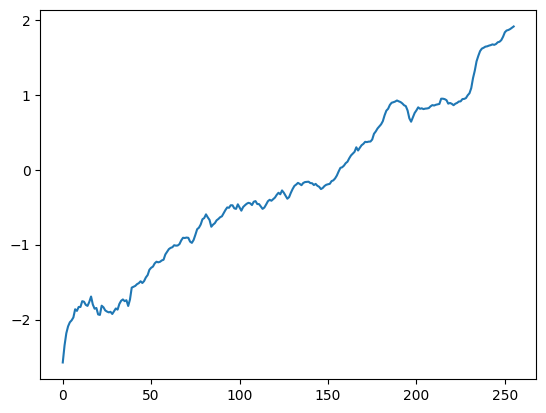

In [26]:
plt.plot(v[0:256]) # note plotting g(z) here not exp(g(z))

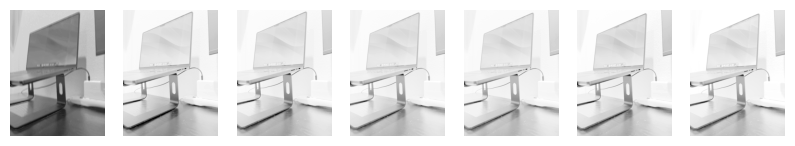

In [27]:
f=plt.figure()
f.set_size_inches(10, 6)
ax = f.add_subplot(1,7,1)
ax.imshow(np.fliplr(np.transpose(np.reshape(v[256:],(h,w)))),cmap="gray")
ax.axis("off")
for i in range(len(Imsr)):
    ax = f.add_subplot(1,7,i+2)
    ax.imshow(np.fliplr(np.transpose(np.log(Imsr[i]+1))),cmap="gray")
    ax.axis("off")


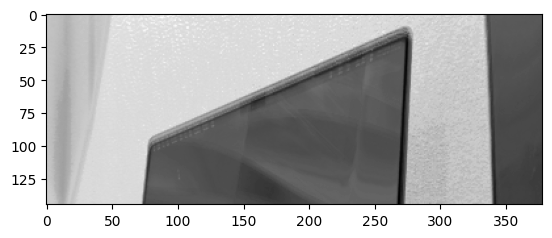

In [28]:
da_Im=np.fliplr(np.transpose(np.reshape(v[256:],(h,w))))
plt.imshow(da_Im[0:145,:],cmap="gray")


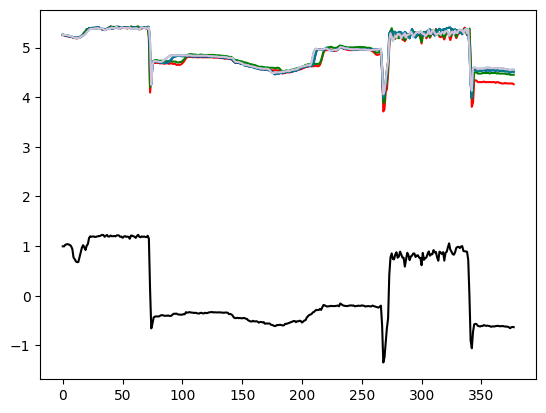

In [29]:
# show one horixontal line (bottom of image above) in each exposure and the high  dynamic range image
# note that the hdr image has detail in both the darker and the lighter areas whereas the individual
# exposures lack detail in one (e.g. no dark detail in red) or the other (no light detail in cyan)
plt.plot(da_Im[145,:],'k')
plt.plot(np.flipud(np.log(Imsr[0][:,145])),color='r')
plt.plot(np.flipud(np.log(Imsr[1][:,145])),color='g')
plt.plot(np.flipud(np.log(Imsr[2][:,145])),color='b')
plt.plot(np.flipud(np.log(Imsr[3][:,145])),color='c')
plt.plot(np.flipud(np.log(Imsr[2][:,145])),color='teal')
plt.plot(np.flipud(np.log(Imsr[3][:,145])),color='thistle')
# plotted logs to make it easier to see variations